In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt
from tensorflow import keras
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sklearn
import os
import glob
from scipy import stats
import math
import pandas as pd
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from stellargraph.layer import GCN_LSTM
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
#load data 
df_list = []
path = r'F:\OneDrive - Nanyang Technological University\PhD Study\P10_TBM positional optimization\Original data'
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
TBMParameters = pd.DataFrame(frame, columns =['[19]Thrust Force','[20]Penetration',
                                           '[25]CHD Torque','[26]CHD RPM','[68]Earth Pressure(LM)','[71]Earth Pressure(RM)',
                                           '[262]Thrust Cylinders Right (Group A)','[263]Thrust Cylinders Down(Group B)',
                                           '[264]Thrust Cylinders Left (Group C)','[265]Thrust Cylinders Top(Group D)',
                                           '[21]Articulation Displacement A','[22]Articulation Displacement B',
                                           '[23]Articulation Displacement C','[24]Articulation Displacement D',
                                              '[85]H Deviation (Art)','[86]H Deviation (Tail)',
                                           '[88]V Deviation (Art)','[89]V Deviation (Tail)'])
                                             
TBMParameters = TBMParameters.apply(pd.to_numeric, errors='coerce')
#Remove nan
TBMParameters = TBMParameters.dropna()
TBMParameters = TBMParameters.loc[(TBMParameters!=0).all(1)]
TBMParameters = TBMParameters[(np.abs(stats.zscore(TBMParameters)) < 3).all(axis=1)]

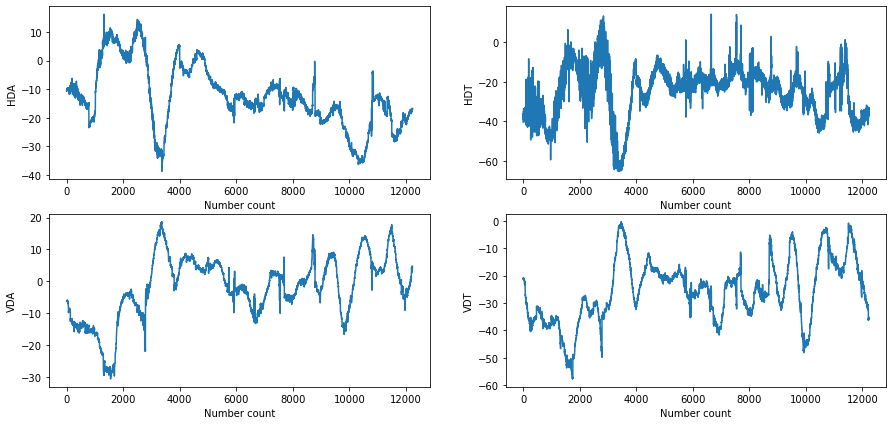

In [9]:
#reconstruct the data for actual displacement
values = TBMParameters.values
values=values.astype('float32')

HDA = values[:,14]
HDT = values[:,15]
VDA = values[:,16]
VDT = values[:,17]

num = len(values[:,14])

#plot
import seaborn as sns
plt.figure(figsize=(15,7))
plt.subplot(221)
sns.lineplot(x=np.linspace(1,num,num), y=values[:,14],color = "tab:blue")
plt.xlabel('Number count')
plt.ylabel('HDA')
plt.subplot(222)
sns.lineplot(x=np.linspace(1,num,num), y=values[:,15],color = "tab:blue")
plt.xlabel('Number count')
plt.ylabel('HDT')
plt.subplot(223)
sns.lineplot(x=np.linspace(1,num,num), y=values[:,16],color = "tab:blue")
plt.xlabel('Number count')
plt.ylabel('VDA')
plt.subplot(224)
sns.lineplot(x=np.linspace(1,num,num), y=values[:,17],color = "tab:blue")
plt.xlabel('Number count')
plt.ylabel('VDT')
plt.savefig("Original deviations.svg")

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
num_of_data_series = 2
num_of_t_for_prediction = 1
reframe = series_to_supervised(scaled, num_of_data_series, num_of_t_for_prediction)
reframe.head()

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t)
2,0.551199,0.600000,0.193869,0.517857,0.271429,0.157895,0.317514,0.262946,0.657534,0.304965,...,0.712603,0.297499,0.15,0.636364,0.636364,0.434783,0.511840,0.323604,0.495951,0.640000
3,0.548590,0.600000,0.272577,0.500000,0.235714,0.127820,0.333051,0.254241,0.683014,0.293393,...,0.718082,0.296379,0.15,0.636364,0.636364,0.434783,0.520947,0.346447,0.497976,0.640000
4,0.549170,0.600000,0.318144,0.500000,0.200000,0.120301,0.316949,0.214509,0.712603,0.297499,...,0.604931,0.286674,0.15,0.636364,0.636364,0.434783,0.517304,0.355330,0.497976,0.641739
5,0.507501,0.622222,0.346313,0.500000,0.092857,0.045113,0.285311,0.153571,0.718082,0.296379,...,0.651781,0.306831,0.15,0.590909,0.636364,0.434783,0.519126,0.369289,0.495951,0.640000
6,0.510544,0.600000,0.324772,0.500000,0.142857,0.097744,0.346045,0.230580,0.604931,0.286674,...,0.643836,0.292273,0.15,0.590909,0.636364,0.434783,0.519126,0.361675,0.495951,0.640000


C:\Users\Fu Xianlei\AppData\Local\Temp\ipykernel_10228\1165958080.py:17: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  gcn_lstm_HDA = GCN_LSTM(


Epoch 1/30
306/306 - 7s - loss: 0.0083 - val_loss: 6.0219e-04
Epoch 2/30
306/306 - 7s - loss: 0.0011 - val_loss: 7.3783e-04
Epoch 3/30
306/306 - 7s - loss: 9.2546e-04 - val_loss: 2.8673e-04
Epoch 4/30
306/306 - 7s - loss: 8.2827e-04 - val_loss: 4.6901e-04
Epoch 5/30
306/306 - 7s - loss: 6.9662e-04 - val_loss: 2.6777e-04
Epoch 6/30
306/306 - 7s - loss: 6.6609e-04 - val_loss: 3.2708e-04
Epoch 7/30
306/306 - 7s - loss: 7.6816e-04 - val_loss: 2.5978e-04
Epoch 8/30
306/306 - 7s - loss: 6.6458e-04 - val_loss: 0.0016
Epoch 9/30
306/306 - 7s - loss: 5.9010e-04 - val_loss: 2.4261e-04
Epoch 10/30
306/306 - 7s - loss: 6.1630e-04 - val_loss: 2.9250e-04
Epoch 11/30
306/306 - 7s - loss: 5.9686e-04 - val_loss: 2.5069e-04
Epoch 12/30
306/306 - 7s - loss: 6.3751e-04 - val_loss: 6.1920e-04
Epoch 13/30
306/306 - 7s - loss: 5.7411e-04 - val_loss: 3.2159e-04
Epoch 14/30
306/306 - 7s - loss: 5.4053e-04 - val_loss: 3.8145e-04
Epoch 15/30
306/306 - 7s - loss: 5.6457e-04 - val_loss: 3.5547e-04
Epoch 16/30
306/

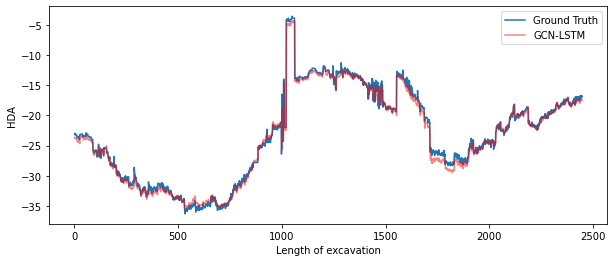

In [11]:
#Do HDA

gcn_lstm_HDA=[]
x_input = []
x_output = []

#Split data for training and testing
reframed=reframe.values
train = reframed[:int(reframed.shape[0]*0.8), :]
test = reframed[int(reframed.shape[0]*0.8):, :]
train_X, train_y = train[:,:-4], train[:,-4]
test_X, test_y = test[:,:-4], test[:,-4]

#Model training
adj = np.identity(train_X.shape[1])

gcn_lstm_HDA = GCN_LSTM(
    seq_len=1,
    adj=adj,
    gc_layer_sizes=[12, 12],
    gc_activations=["tanh", "tanh"],
    lstm_layer_sizes=[256, 128, 64],
    lstm_activations=["elu", "elu", "elu"],
)

x_input, x_output = gcn_lstm_HDA.in_out_tensors()
#x_output = Dense(units=1, activation="relu")(x_output)

model_HDA = Model(inputs=x_input, outputs=x_output)
model_HDA.compile(loss = "mean_squared_error", optimizer = 'adam')
history_HDA = model_HDA.fit(train_X,train_y,epochs=30,batch_size=32,verbose=2,validation_data=(test_X, test_y))

#Output result
y_predict = model_HDA.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
y_predict = y_predict[:,0].reshape(len(y_predict[:,0]),1)

# invert scaling for forecast
inv_y_test = np.concatenate((test_X,y_predict,test[:,-3:]), axis=1)
inv_y_test = inv_y_test[:,-18:]
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-4]
 
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X,test_y,test[:,-3:]), axis=1)
inv_y_train = inv_y_train[:,-18:]
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -4]

mae = mean_absolute_error(inv_y, inv_y_predict)
rmse = sqrt(mean_squared_error(inv_y, inv_y_predict))
r2 = r2_score(inv_y, inv_y_predict)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)
print(r2)

#plot
import seaborn as sns
number1 = len(inv_y)
plt.figure(figsize=(10, 4))
sns.lineplot(x=np.linspace(1,number1,number1), y=inv_y,color = "tab:blue", label='Ground Truth')
sns.lineplot(x=np.linspace(1,number1,number1), y=inv_y_predict,color = "red", label='GCN-LSTM', alpha=0.5)
plt.xlabel('Length of excavation')
plt.ylabel('HDA')
plt.show()

#save the result
actual_HDA = inv_y
predict_HDA = inv_y_predict
#np.savetxt('actual_HDA.csv',actual_HDA,delimiter=',')
#np.savetxt('predict_HDA.csv',predict_HDA,delimiter=',')

C:\Users\Fu Xianlei\AppData\Local\Temp\ipykernel_10228\2404210388.py:17: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  gcn_lstm_HDT = GCN_LSTM(


Epoch 1/30
306/306 - 7s - loss: 0.0088 - val_loss: 0.0020
Epoch 2/30
306/306 - 6s - loss: 0.0035 - val_loss: 0.0025
Epoch 3/30
306/306 - 6s - loss: 0.0033 - val_loss: 0.0018
Epoch 4/30
306/306 - 6s - loss: 0.0033 - val_loss: 0.0018
Epoch 5/30
306/306 - 6s - loss: 0.0030 - val_loss: 0.0016
Epoch 6/30
306/306 - 6s - loss: 0.0030 - val_loss: 0.0020
Epoch 7/30
306/306 - 6s - loss: 0.0029 - val_loss: 0.0019
Epoch 8/30
306/306 - 6s - loss: 0.0029 - val_loss: 0.0017
Epoch 9/30
306/306 - 6s - loss: 0.0029 - val_loss: 0.0025
Epoch 10/30
306/306 - 6s - loss: 0.0029 - val_loss: 0.0019
Epoch 11/30
306/306 - 6s - loss: 0.0029 - val_loss: 0.0022
Epoch 12/30
306/306 - 6s - loss: 0.0029 - val_loss: 0.0018
Epoch 13/30
306/306 - 6s - loss: 0.0028 - val_loss: 0.0023
Epoch 14/30
306/306 - 6s - loss: 0.0028 - val_loss: 0.0026
Epoch 15/30
306/306 - 6s - loss: 0.0027 - val_loss: 0.0018
Epoch 16/30
306/306 - 6s - loss: 0.0029 - val_loss: 0.0028
Epoch 17/30
306/306 - 6s - loss: 0.0028 - val_loss: 0.0022
Epoch 

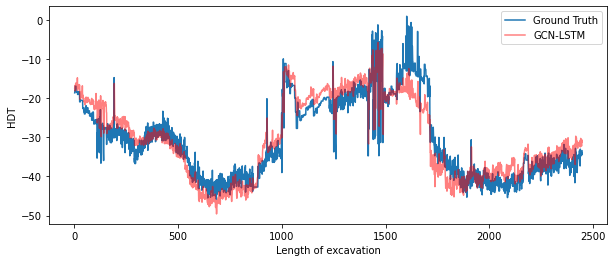

In [12]:
#Do HDT

gcn_lstm_HDT = []
x_input = []
x_output = []

#Split data for training and testing
reframed=reframe.values
train = reframed[:int(reframed.shape[0]*0.8), :]
test = reframed[int(reframed.shape[0]*0.8):, :]
train_X, train_y = train[:,:-4], train[:,-3]
test_X, test_y = test[:,:-4], test[:,-3]

#Model training
adj = np.identity(train_X.shape[1])

gcn_lstm_HDT = GCN_LSTM(
    seq_len=1,
    adj=adj,
    gc_layer_sizes=[12, 12],
    gc_activations=["tanh", "tanh"],
    lstm_layer_sizes=[256, 128, 64],
    lstm_activations=["elu", "elu", "elu"],
)

x_input, x_output = gcn_lstm_HDT.in_out_tensors()
#x_output = Dense(units=1, activation="relu")(x_output)

model_HDT = Model(inputs=x_input, outputs=x_output)
model_HDT.compile(loss = "mean_squared_error", optimizer = 'adam')
history_HDT = model_HDT.fit(train_X,train_y,epochs=30,batch_size=32,verbose=2,validation_data=(test_X, test_y))

#Output result
y_predict = model_HDT.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
y_predict = y_predict[:,0].reshape(len(y_predict[:,0]),1)

# invert scaling for forecast
inv_y_test = np.concatenate((test_X,test[:,-3:-2],y_predict,test[:,-2:]), axis=1)
inv_y_test = inv_y_test[:,-18:]
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-3]
 
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X,test[:,-3:-2],test_y,test[:,-2:]), axis=1)
inv_y_train = inv_y_train[:,-18:]
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -3]

mae = mean_absolute_error(inv_y, inv_y_predict)
rmse = sqrt(mean_squared_error(inv_y, inv_y_predict))
r2 = r2_score(inv_y, inv_y_predict)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)
print(r2)

#plot
number1 = len(inv_y)
plt.figure(figsize=(10, 4))
sns.lineplot(x=np.linspace(1,number1,number1), y=inv_y,color = "tab:blue", label='Ground Truth')
sns.lineplot(x=np.linspace(1,number1,number1), y=inv_y_predict,color = "red", label='GCN-LSTM', alpha=0.5)
plt.xlabel('Length of excavation')
plt.ylabel('HDT')
plt.show()

#save the result
actual_HDT = inv_y
predict_HDT = inv_y_predict
#np.savetxt('actual_HDT.csv',actual_HDT,delimiter=',')
#np.savetxt('predict_HDT.csv',predict_HDT,delimiter=',')

C:\Users\Fu Xianlei\AppData\Local\Temp\ipykernel_10228\3121683017.py:17: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  gcn_lstm_VDA = GCN_LSTM(


Epoch 1/30
306/306 - 6s - loss: 0.0122 - val_loss: 0.0031
Epoch 2/30
306/306 - 6s - loss: 0.0015 - val_loss: 8.8553e-04
Epoch 3/30
306/306 - 6s - loss: 0.0011 - val_loss: 6.1053e-04
Epoch 4/30
306/306 - 6s - loss: 8.5188e-04 - val_loss: 4.2286e-04
Epoch 5/30
306/306 - 6s - loss: 8.8602e-04 - val_loss: 0.0014
Epoch 6/30
306/306 - 6s - loss: 7.2944e-04 - val_loss: 8.6712e-04
Epoch 7/30
306/306 - 6s - loss: 7.0602e-04 - val_loss: 4.3031e-04
Epoch 8/30
306/306 - 6s - loss: 7.2658e-04 - val_loss: 7.0364e-04
Epoch 9/30
306/306 - 6s - loss: 6.3094e-04 - val_loss: 3.1265e-04
Epoch 10/30
306/306 - 6s - loss: 6.6683e-04 - val_loss: 6.6125e-04
Epoch 11/30
306/306 - 6s - loss: 5.9536e-04 - val_loss: 3.8048e-04
Epoch 12/30
306/306 - 6s - loss: 6.7555e-04 - val_loss: 4.5778e-04
Epoch 13/30
306/306 - 6s - loss: 5.8719e-04 - val_loss: 0.0013
Epoch 14/30
306/306 - 6s - loss: 6.7398e-04 - val_loss: 3.0795e-04
Epoch 15/30
306/306 - 6s - loss: 5.7947e-04 - val_loss: 3.5918e-04
Epoch 16/30
306/306 - 6s - l

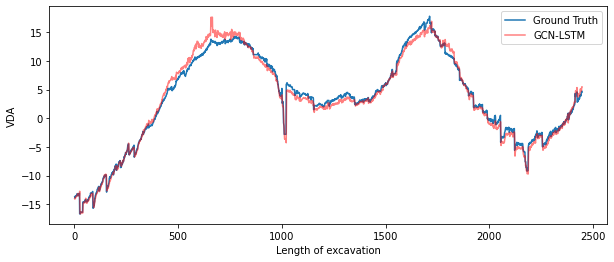

In [13]:
#Do VDA

gcn_lstm_VDA = []
x_input = []
x_output = []

#Split data for training and testing
reframed=reframe.values
train = reframed[:int(reframed.shape[0]*0.8), :]
test = reframed[int(reframed.shape[0]*0.8):, :]
train_X, train_y = train[:,:-4], train[:,-2]
test_X, test_y = test[:,:-4], test[:,-2]

#Model training
adj = np.identity(train_X.shape[1])

gcn_lstm_VDA = GCN_LSTM(
    seq_len=1,
    adj=adj,
    gc_layer_sizes=[12, 12],
    gc_activations=["tanh", "tanh"],
    lstm_layer_sizes=[256, 128, 64],
    lstm_activations=["elu", "elu", "elu"],
)

x_input, x_output = gcn_lstm_VDA.in_out_tensors()
#x_output = Dense(units=1, activation="relu")(x_output)

model_VDA = Model(inputs=x_input, outputs=x_output)
model_VDA.compile(loss = "mean_squared_error", optimizer = 'adam')
history_VDA = model_VDA.fit(train_X,train_y,epochs=30,batch_size=32,verbose=2,validation_data=(test_X, test_y))

#Output result
y_predict = model_VDA.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
y_predict = y_predict[:,0].reshape(len(y_predict[:,0]),1)

# invert scaling for forecast
inv_y_test = np.concatenate((test_X,test[:,-3:-1],y_predict,test[:,-1:]), axis=1)
inv_y_test = inv_y_test[:,-18:]
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-2]
 
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X,test[:,-3:-1],test_y,test[:,-1:]), axis=1)
inv_y_train = inv_y_train[:,-18:]
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -2]

mae = mean_absolute_error(inv_y, inv_y_predict)
rmse = sqrt(mean_squared_error(inv_y, inv_y_predict))
r2 = r2_score(inv_y, inv_y_predict)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)
print(r2)

#plot
number1 = len(inv_y)
plt.figure(figsize=(10, 4))
sns.lineplot(x=np.linspace(1,number1,number1), y=inv_y,color = "tab:blue", label='Ground Truth')
sns.lineplot(x=np.linspace(1,number1,number1), y=inv_y_predict,color = "red", label='GCN-LSTM', alpha=0.5)
plt.xlabel('Length of excavation')
plt.ylabel('VDA')
plt.show()

#save the result
actual_VDA = inv_y
predict_VDA = inv_y_predict
#np.savetxt('actual_VDA.csv',actual_VDA,delimiter=',')
#np.savetxt('predict_VDA.csv',predict_VDA,delimiter=',')

C:\Users\Fu Xianlei\AppData\Local\Temp\ipykernel_10228\3064891651.py:17: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  gcn_lstm_VDT = GCN_LSTM(


Epoch 1/30
306/306 - 7s - loss: 0.0066 - val_loss: 8.6589e-04
Epoch 2/30
306/306 - 6s - loss: 0.0011 - val_loss: 2.4985e-04
Epoch 3/30
306/306 - 6s - loss: 7.8110e-04 - val_loss: 7.9297e-04
Epoch 4/30
306/306 - 6s - loss: 6.8910e-04 - val_loss: 7.5982e-04
Epoch 5/30
306/306 - 6s - loss: 6.5001e-04 - val_loss: 5.7713e-04
Epoch 6/30
306/306 - 6s - loss: 5.6689e-04 - val_loss: 1.9499e-04
Epoch 7/30
306/306 - 6s - loss: 5.7381e-04 - val_loss: 2.7000e-04
Epoch 8/30
306/306 - 6s - loss: 5.6151e-04 - val_loss: 2.2809e-04
Epoch 9/30
306/306 - 6s - loss: 5.1882e-04 - val_loss: 2.9486e-04
Epoch 10/30
306/306 - 6s - loss: 5.7738e-04 - val_loss: 3.9514e-04
Epoch 11/30
306/306 - 6s - loss: 5.1446e-04 - val_loss: 2.6051e-04
Epoch 12/30
306/306 - 6s - loss: 5.3207e-04 - val_loss: 3.2778e-04
Epoch 13/30
306/306 - 6s - loss: 5.3438e-04 - val_loss: 2.1987e-04
Epoch 14/30
306/306 - 6s - loss: 5.1343e-04 - val_loss: 6.6046e-04
Epoch 15/30
306/306 - 6s - loss: 4.5950e-04 - val_loss: 5.0991e-04
Epoch 16/30


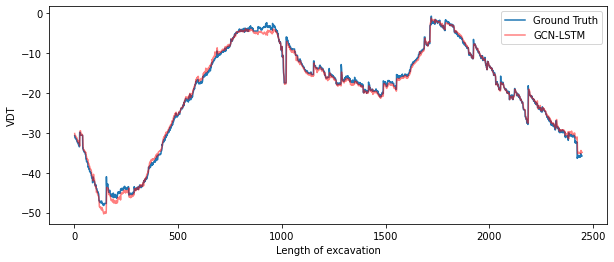

In [14]:
#Do VDT

gcn_lstm_VDT=[]
x_input = []
x_output = []

#Split data for training and testing
reframed=reframe.values
train = reframed[:int(reframed.shape[0]*0.8), :]
test = reframed[int(reframed.shape[0]*0.8):, :]
train_X, train_y = train[:,:-4], train[:,-1]
test_X, test_y = test[:,:-4], test[:,-1]

#Model training
adj = np.identity(train_X.shape[1])

gcn_lstm_VDT = GCN_LSTM(
    seq_len=1,
    adj=adj,
    gc_layer_sizes=[12, 12],
    gc_activations=["tanh", "tanh"],
    lstm_layer_sizes=[256, 128, 64],
    lstm_activations=["elu", "elu", "elu"],
)

x_input, x_output = gcn_lstm_VDT.in_out_tensors()
#x_output = Dense(units=1, activation="relu")(x_output)

model_VDT = Model(inputs=x_input, outputs=x_output)
model_VDT.compile(loss = "mean_squared_error", optimizer = 'adam')
history_VDT = model_VDT.fit(train_X,train_y,epochs=30,batch_size=32,verbose=2,validation_data=(test_X, test_y))

#Output result
y_predict = model_VDT.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
y_predict = y_predict[:,0].reshape(len(y_predict[:,0]),1)

# invert scaling for forecast
inv_y_test = np.concatenate((test_X,test[:,-3:],y_predict), axis=1)
inv_y_test = inv_y_test[:,-18:]
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-1]
 
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X,test[:,-3:],test_y), axis=1)
inv_y_train = inv_y_train[:,-18:]
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]

mae = mean_absolute_error(inv_y, inv_y_predict)
rmse = sqrt(mean_squared_error(inv_y, inv_y_predict))
r2 = r2_score(inv_y, inv_y_predict)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)
print(r2)

#plot
number1 = len(inv_y)
plt.figure(figsize=(10, 4))
sns.lineplot(x=np.linspace(1,number1,number1), y=inv_y,color = "tab:blue", label='Ground Truth')
sns.lineplot(x=np.linspace(1,number1,number1), y=inv_y_predict,color = "red", label='GCN-LSTM', alpha=0.5)
plt.xlabel('Length of excavation')
plt.ylabel('VDT')
plt.show()

#save the result
actual_VDT = inv_y
predict_VDT = inv_y_predict
#np.savetxt('actual_VDT.csv',actual_VDT,delimiter=',')
#np.savetxt('predict_VDT.csv',predict_VDT,delimiter=',')

In [30]:
#Save models
model_HDA.save("model_HDA")
model_HDT.save("model_HDT")
model_VDA.save("model_VDA")
model_VDT.save("model_VDT")

INFO:tensorflow:Assets written to: model_HDA\assets
INFO:tensorflow:Assets written to: model_HDT\assets
INFO:tensorflow:Assets written to: model_VDA\assets
INFO:tensorflow:Assets written to: model_VDT\assets


Test MAE: 0.671
Test RMSE: 0.997
0.9839682698829203


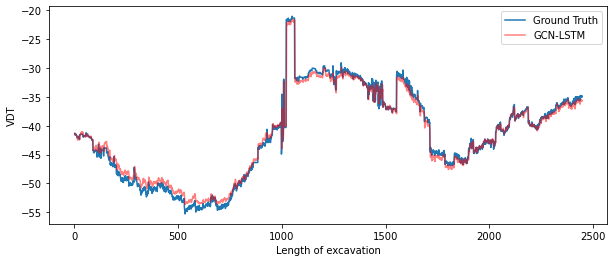

In [57]:
#Output result
y_predict = model_HDA.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
y_predict = y_predict[:,0].reshape(len(y_predict[:,0]),1)

# invert scaling for forecast
inv_y_test = np.concatenate((test_X,test[:,-3:],y_predict), axis=1)
inv_y_test = inv_y_test[:,-18:]
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-1]
 
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X,test[:,-3:],test_y), axis=1)
inv_y_train = inv_y_train[:,-18:]
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]

mae = mean_absolute_error(inv_y, inv_y_predict)
rmse = sqrt(mean_squared_error(inv_y, inv_y_predict))
r2 = r2_score(inv_y, inv_y_predict)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)
print(r2)

#plot
number1 = len(inv_y)
plt.figure(figsize=(10, 4))
sns.lineplot(x=np.linspace(1,number1,number1), y=inv_y,color = "tab:blue", label='Ground Truth')
sns.lineplot(x=np.linspace(1,number1,number1), y=inv_y_predict,color = "red", label='GCN-LSTM', alpha=0.5)
plt.xlabel('Length of excavation')
plt.ylabel('VDT')
plt.show()